# ConvLSTM Expl: Convolutional LSTM Network Tutorial

### This notebook demonstrates the use of a convolutional LSTM network.

This network is used to predict the next frame of an artificially
generated movie which contains moving squares.

## Imports

## IMPORTS

In [8]:
import os
import numpy as np
from glob import glob
import cv2
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import ConvLSTM2D, BatchNormalization, Conv3D
from tensorflow.keras.optimizers import Adadelta
from sklearn.model_selection import train_test_split



In [9]:
# ==========================================
# 1️⃣ Load image sequences from all runs
# ==========================================

def load_runs(base_dir="bacteria_growth", img_size=40):
    runs = sorted(glob(os.path.join(base_dir, "run_*")))
    all_sequences = []

    for run_path in runs:
        frames = sorted(glob(os.path.join(run_path, "frame_*.png")))
        imgs = []
        for f in frames:
            img = cv2.imread(f, cv2.IMREAD_GRAYSCALE)
            img = cv2.resize(img, (img_size, img_size))
            img = img.astype(np.float32) / 255.0
            imgs.append(img)
        all_sequences.append(np.stack(imgs, axis=0))  # shape: (T, H, W)
    return all_sequences

sequences = load_runs("bacteria_growth", img_size=40)



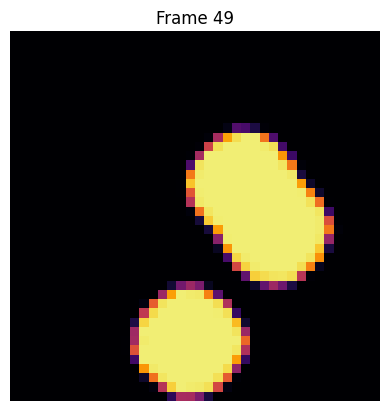

In [10]:
import matplotlib.pyplot as plt
from IPython.display import HTML
import matplotlib.animation as animation

# Pick a run (e.g., the first one)
seq = sequences[0]

fig, ax = plt.subplots()
im = ax.imshow(seq[0], cmap='inferno', vmin=0, vmax=1)
ax.axis('off')

def update(frame):
    im.set_data(seq[frame])
    ax.set_title(f"Frame {frame}")
    return [im]

ani = animation.FuncAnimation(fig, update, frames=len(seq), interval=200, blit=True)
HTML(ani.to_jshtml())


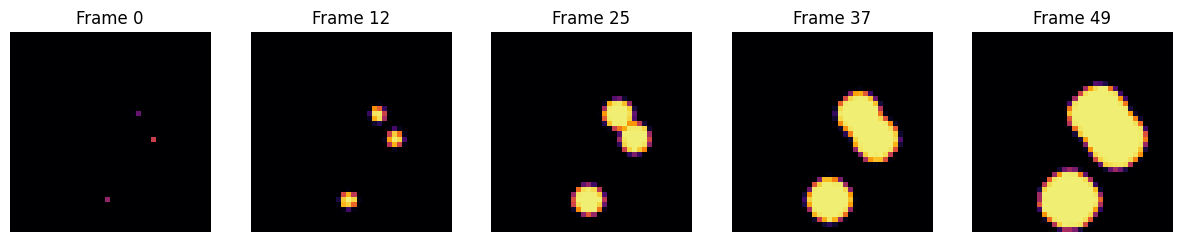

In [11]:
import matplotlib.pyplot as plt

seq = sequences[0]  # pick a run
frames_to_show = [0, len(seq)//4, len(seq)//2, 3*len(seq)//4, len(seq)-1]

plt.figure(figsize=(15, 3))
for i, f in enumerate(frames_to_show):
    plt.subplot(1, len(frames_to_show), i+1)
    plt.imshow(seq[f], cmap='inferno', vmin=0, vmax=1)
    plt.title(f"Frame {f}")
    plt.axis('off')
plt.show()


In [21]:
# ==========================================
# 2️⃣ Create training windows (input/output pairs)
# ==========================================

def create_input_output_pairs(sequences, input_len=5, pred_len=5, stride=1):
    X, Y = [], []
    for seq in sequences:
        T = seq.shape[0]
        for start in range(0, T - input_len - pred_len + 1, stride):
            x = seq[start : start + input_len]
            y = seq[start + input_len : start + input_len + pred_len]
            X.append(x)
            Y.append(y)
    X = np.expand_dims(np.array(X), -1)  # (num_samples, input_len, H, W, 1)
    Y = np.expand_dims(np.array(Y), -1)  # (num_samples, pred_len, H, W, 1)
    return X, Y

X, Y = create_input_output_pairs(sequences, input_len=5, pred_len=5, stride=1)

print("Input shape:", X.shape, "Target shape:", Y.shape)



Input shape: (410, 5, 40, 40, 1) Target shape: (410, 5, 40, 40, 1)


Input shape: (410, 5, 40, 40, 1)
Target shape: (410, 5, 40, 40, 1)

Sample index: 257
x_sample shape: (5, 40, 40, 1)
y_sample shape: (5, 40, 40, 1)


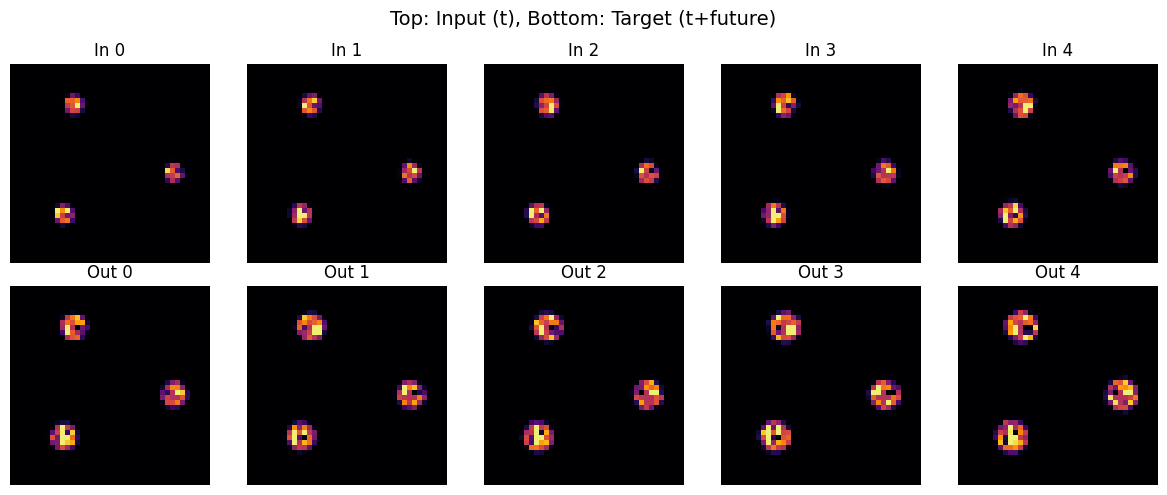

In [22]:
import matplotlib.pyplot as plt

# Print shapes
print("Input shape:", X.shape)   # (num_samples, input_len, H, W, 1)
print("Target shape:", Y.shape)  # (num_samples, pred_len, H, W, 1)

# Pick a random sample
idx = np.random.randint(0, len(X))
x_sample = X[idx]  # shape (input_len, H, W, 1)
y_sample = Y[idx]  # shape (pred_len, H, W, 1)

print(f"\nSample index: {idx}")
print("x_sample shape:", x_sample.shape)
print("y_sample shape:", y_sample.shape)

# Visualize
fig, axes = plt.subplots(2, 5, figsize=(12, 5))
fig.suptitle("Top: Input (t), Bottom: Target (t+future)", fontsize=14)

for i in range(5):
    # Input frames
    axes[0, i].imshow(x_sample[i, :, :, 0], cmap='inferno', vmin=0, vmax=1)
    axes[0, i].set_title(f"In {i}")
    axes[0, i].axis('off')
    
    # Target frames
    axes[1, i].imshow(y_sample[i, :, :, 0], cmap='inferno', vmin=0, vmax=1)
    axes[1, i].set_title(f"Out {i}")
    axes[1, i].axis('off')

plt.tight_layout()
plt.show()


In [23]:
# ==========================================
# 3️⃣ Train/validation split
# ==========================================

X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=0.2, random_state=42)

print("Training set:", X_train.shape, Y_train.shape)
print("Validation set:", X_val.shape, Y_val.shape)



Training set: (328, 5, 40, 40, 1) (328, 5, 40, 40, 1)
Validation set: (82, 5, 40, 40, 1) (82, 5, 40, 40, 1)


In [24]:
# ==========================================
# 4️⃣ Define ConvLSTM model
# ==========================================

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import ConvLSTM2D, BatchNormalization, Conv3D
from tensorflow.keras.optimizers import Adadelta

model = Sequential([
    ConvLSTM2D(filters=40, kernel_size=(3, 3), input_shape=(None, 40, 40, 1),
               padding='same', return_sequences=True),
    BatchNormalization(),

    ConvLSTM2D(filters=40, kernel_size=(3, 3), padding='same', return_sequences=True),
    BatchNormalization(),

    ConvLSTM2D(filters=40, kernel_size=(3, 3), padding='same', return_sequences=True),
    BatchNormalization(),

    ConvLSTM2D(filters=40, kernel_size=(3, 3), padding='same', return_sequences=True),
    BatchNormalization(),

    # Use temporal kernel of 1 → preserves number of frames (time dimension)
    Conv3D(filters=1, kernel_size=(1, 3, 3), activation='sigmoid',
           padding='same', data_format='channels_last')
])

model.compile(loss='binary_crossentropy', optimizer=Adadelta())
model.summary()


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv_lstm2d_16 (ConvLSTM2D)     │ (None, None, 40, 40,   │        59,200 │
│                                 │ 40)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_16          │ (None, None, 40, 40,   │           160 │
│ (BatchNormalization)            │ 40)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_lstm2d_17 (ConvLSTM2D)     │ (None, None, 40, 40,   │       115,360 │
│                                 │ 40)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_17          │ (None, None, 40, 40,   │           160 │
│ (BatchNormalization)            │ 40)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_lstm2d_18 (ConvLSTM2D)     │ (None, None, 40, 40,   │       115,360 │
│                                 │ 40)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_18          │ (None, None, 40, 40,   │           160 │
│ (BatchNormalization)            │ 40)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_lstm2d_19 (ConvLSTM2D)     │ (None, None, 40, 40,   │       115,360 │
│                                 │ 40)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_19          │ (None, None, 40, 40,   │           160 │
│ (BatchNormalization)            │ 40)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_4 (Conv3D)               │ (None, None, 40, 40,   │           361 │
│                                 │ 1)                     │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 406,281 (1.55 MB)

 Trainable params: 405,961 (1.55 MB)

 Non-trainable params: 320 (1.25 KB)

In [31]:

# ==========================================
# 5️⃣ Train
# ==========================================

history = model.fit(
    X_train, Y_train,
    batch_size=4,
    epochs=100,
    validation_data=(X_val, Y_val)
)


Epoch 1/100
82/82 ━━━━━━━━━━━━━━━━━━━━ 14s 171ms/step - loss: 0.6616 - val_loss: 0.7164
Epoch 2/100
82/82 ━━━━━━━━━━━━━━━━━━━━ 14s 176ms/step - loss: 0.6230 - val_loss: 0.7665
Epoch 3/100
82/82 ━━━━━━━━━━━━━━━━━━━━ 14s 174ms/step - loss: 0.5917 - val_loss: 0.8437
Epoch 4/100
82/82 ━━━━━━━━━━━━━━━━━━━━ 15s 177ms/step - loss: 0.5663 - val_loss: 0.8793
Epoch 5/100
82/82 ━━━━━━━━━━━━━━━━━━━━ 16s 196ms/step - loss: 0.5470 - val_loss: 0.8040
Epoch 6/100
82/82 ━━━━━━━━━━━━━━━━━━━━ 16s 196ms/step - loss: 0.5328 - val_loss: 0.6736
Epoch 7/100
82/82 ━━━━━━━━━━━━━━━━━━━━ 16s 195ms/step - loss: 0.5116 - val_loss: 0.5822
Epoch 8/100
82/82 ━━━━━━━━━━━━━━━━━━━━ 16s 195ms/step - loss: 0.4974 - val_loss: 0.5276
Epoch 9/100
82/82 ━━━━━━━━━━━━━━━━━━━━ 17s 206ms/step - loss: 0.4864 - val_loss: 0.4877
Epoch 10/100
82/82 ━━━━━━━━━━━━━━━━━━━━ 16s 200ms/step - loss: 0.4726 - val_loss: 0.4665
Epoch 11/100
82/82 ━━━━━━━━━━━━━━━━━━━━ 16s 198ms/step - loss: 0.4700 - val_loss: 0.4505
Epoch 12/100
82/82 ━━━━━━━━━━━

In [32]:

# ==========================================
# 6️⃣ Evaluate using offset prediction
# ==========================================

def offset_prediction(model, seq, input_len=5, pred_len=10, offset=0):
    """
    Predict future frames given a starting offset.
    Example: offset=0 → use frames [0–4] → predict [5–14]
             offset=4 → use frames [4–8] → predict [9–18]
    """
    start = offset
    input_seq = seq[start:start + input_len]
    input_seq = np.expand_dims(np.expand_dims(input_seq, axis=0), -1)  # (1, t, H, W, 1)
    pred = model.predict(input_seq)
    return pred[0, :, :, :, 0]

# Example usage on first validation sequence:
example_seq = X_val[0, :, :, :, 0]  # original frames
predicted_future = offset_prediction(model, X_val[0, :, :, :, 0], input_len=5, pred_len=5, offset=0)


print("Predicted future shape:", predicted_future.shape)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
Predicted future shape: (5, 40, 40)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


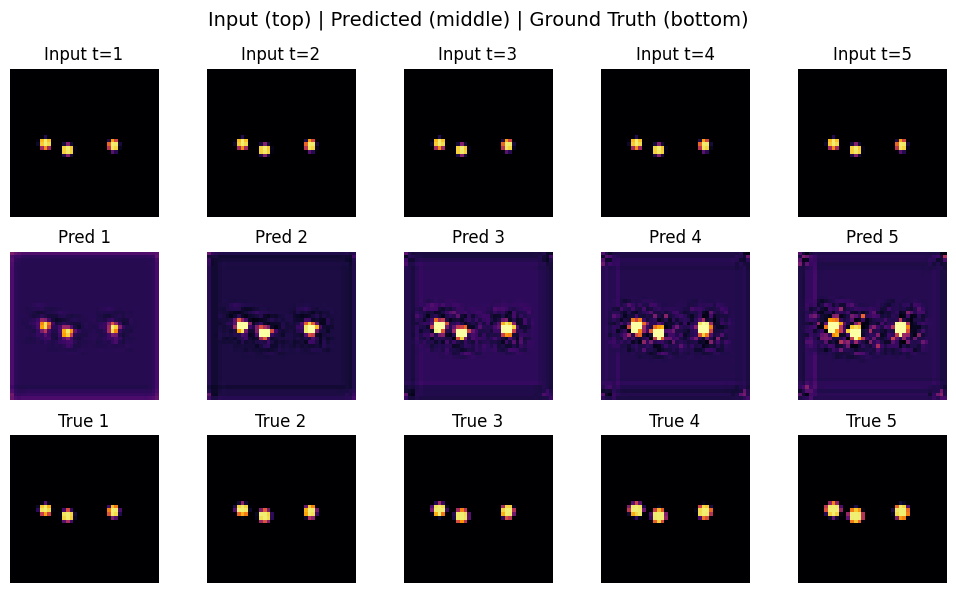

In [33]:
import matplotlib.pyplot as plt

# ✅ Corrected: use X_val as input, Y_val as ground truth
input_len = 5
pred_len = 5

input_seq = X_val[0, :, :, :, 0]
true_future = Y_val[0, :, :, :, 0]
predicted_future = offset_prediction(model, X_val[0, :, :, :, 0], input_len=input_len, pred_len=pred_len, offset=0)

# Plot input frames, predicted future, and ground truth future
fig, axes = plt.subplots(3, pred_len, figsize=(pred_len * 2, 6))

for i in range(pred_len):
    # Input (last frame repeated for context)
    axes[0, i].imshow(input_seq[-1], cmap='inferno', vmin=0, vmax=1)
    axes[0, i].set_title(f"Input t={i+1}")
    axes[0, i].axis("off")
    
    # Prediction
    axes[1, i].imshow(predicted_future[i], cmap='inferno', vmin=0, vmax=1)
    axes[1, i].set_title(f"Pred {i+1}")
    axes[1, i].axis("off")
    
    # Ground truth
    axes[2, i].imshow(true_future[i], cmap='inferno', vmin=0, vmax=1)
    axes[2, i].set_title(f"True {i+1}")
    axes[2, i].axis("off")

plt.suptitle("Input (top) | Predicted (middle) | Ground Truth (bottom)", fontsize=14)
plt.tight_layout()
plt.show()
